In [0]:
import numpy as np
import pandas as pd
import os, glob, pathlib
from scipy.stats import describe
import cv2
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import datasets
from sklearn.datasets import fetch_openml

In [0]:
# Fetch MNIST dataset
data, labels = fetch_openml('mnist_784', version=1, return_X_y=True)

In [0]:
def prepare_dataset(data, labels, DATA_SPLIT_RATIO = [0.8,0.1,0.1],retain=None):
    
    N = data.shape[0]
    indices = np.arange(N)
    
    np.random.seed(888)
    np.random.shuffle(indices)
    
    if retain is None:
      retain = N
    indices = indices[:retain]
    
    N = retain
    data = data[indices,:]
    labels = labels[indices]
    
    trainX = data[:int(DATA_SPLIT_RATIO[0]*N),:]
    valX = data[int(DATA_SPLIT_RATIO[0]*N):int((DATA_SPLIT_RATIO[0]+DATA_SPLIT_RATIO[1])*N),:]
    testX = data[int((DATA_SPLIT_RATIO[0]+DATA_SPLIT_RATIO[1])*N):,:]
    trainY = labels[:int(DATA_SPLIT_RATIO[0] * N)]
    valY = labels[int(DATA_SPLIT_RATIO[0] * N):int((DATA_SPLIT_RATIO[0] + DATA_SPLIT_RATIO[1]) * N)]
    testY = labels[int((DATA_SPLIT_RATIO[0] + DATA_SPLIT_RATIO[1]) * N):]

    return trainX,trainY,\
           valX,valY,\
           testX,testY

In [0]:
def get_eigens(data,image_dim,threshold=0.95,visualize=False):
  means = np.mean(data,axis=0)
  mean_centered_images = data - means
  print('Computing covariance matrix...')
  cov = np.cov(np.transpose(mean_centered_images))
  print('Computing eigens...')
  eig_vals, eig_vecs = np.linalg.eig(cov)
  
  percentage_variance_captured = eig_vals * 100.0 / np.sum(eig_vals)
  cummulative_variance_percentage = np.cumsum(percentage_variance_captured)
  if visualize:
    plt.figure()
    plt.plot(cummulative_variance_percentage)
    plt.title('Cummulative Variance Captured By Eigenvector Projections')
    plt.xlabel('Number of eigenvectors')
    plt.ylabel('Percentange of variance captured')
    plt.savefig('cumm_percentage_variance_captured.png')
    plt.show()
    
    plt.figure(figsize=(15,15))
    for i in range(1,16):
      plt.subplot(5,3,i)
      plt.imshow(eig_vecs[:,i-1].reshape(image_dim,image_dim).astype('float'),cmap='gray')
    plt.suptitle('Top 15 Eigenvectors As Images',fontsize=50,)
    plt.savefig('top_15_eigenvecs.png')
    plt.show()
    
  n_retained = np.max(np.where(cummulative_variance_percentage <= threshold*100.0)[0])
  print('Number of eigenvectors to capture %d variance: %d'%(threshold*100,n_retained))
  return means, eig_vals[:n_retained],eig_vecs[:,:n_retained]
  
def get_projections(data,eig_vecs):
  return np.matmul(data,eig_vecs)

In [0]:
trainX,trainY,valX,valY,testX,testY = prepare_dataset(data,labels,DATA_SPLIT_RATIO=[0.6,0.2,0.2],retain=15000)

Computing covariance matrix...
Computing eigens...


/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


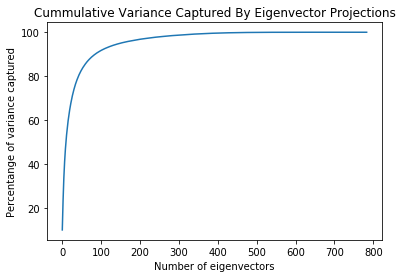

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


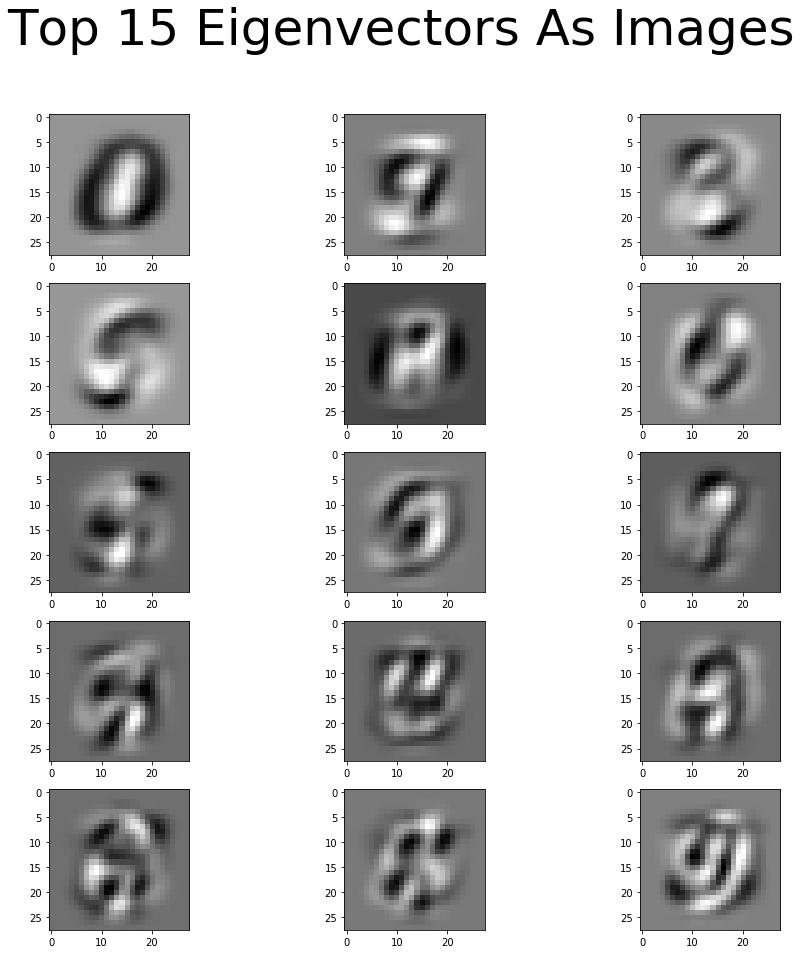

Number of eigenvectors to capture 95 variance: 149


In [61]:
means, eig_vals,eig_vecs = get_eigens(trainX,image_dim=28,visualize=True)
train_projections = get_projections(trainX-means,eig_vecs)
val_projections = get_projections(valX-means,eig_vecs)
test_projections = get_projections(testX-means,eig_vecs)

In [0]:
class KNN:
  def __init__(self,neighborhood=10):
    self.neighborhood = neighborhood
    self.pairwise_distances = None
    
  def set_train_data(self,X,labels):
    self.X = X
    self.labels = labels
    self.pairwise_distances = None
      
  def set_neighborhood(self,neighborhood):
    self.neighborhood = neighborhood
    
  def compute_pairwise_distances(self,Y):
    X2 = np.sum(self.X ** 2,axis=1)
    X2 = X2.reshape(X2.shape+(1,))
    Y2 = np.sum(np.transpose(Y) ** 2,axis=0)
    Y2 = Y2.reshape((1,)+Y2.shape)
    XY = np.matmul(self.X,np.transpose(Y))
    pairwise_distances = X2 + Y2 - 2.0*XY
    self.pairwise_distances = pairwise_distances
    return pairwise_distances
    
  def get_predictions(self,Y):
    if self.pairwise_distances is None:
      self.compute_pairwise_distances(Y)
    closest_neighbors_indices = np.apply_along_axis(lambda x: np.argpartition(x,self.neighborhood)[:self.neighborhood],0,self.pairwise_distances)
    closest_neighbors_labels = np.apply_along_axis(lambda x: np.apply_along_axis(lambda y: self.labels[y],0,x),0,closest_neighbors_indices)
    predictions = np.apply_along_axis(lambda x: stats.mode(x)[0],0,closest_neighbors_labels)
    return predictions
  
  @staticmethod
  def get_accuracy(y_actual, y_pred):
    return 100.0 * np.sum(y_actual == y_pred) / len(y_actual)

In [0]:
val_acc_without_pca = []
val_acc_with_pca = []
knn_without_pca = KNN()
knn_without_pca.set_train_data(trainX,trainY)
knn_with_pca = KNN()
knn_with_pca.set_train_data(train_projections,trainY)

n_arr = np.arange(1,51)

for n in n_arr:
  knn_without_pca.set_neighborhood(n)
  predictions = knn_without_pca.get_predictions(valX)
  accuracy = KNN.get_accuracy(predictions[0,:],valY)
  val_acc_without_pca.append(accuracy)
  
  knn_with_pca.set_neighborhood(n)
  predictions = knn_with_pca.get_predictions(val_projections)
  accuracy = KNN.get_accuracy(predictions[0,:],valY)
  val_acc_with_pca.append(accuracy)


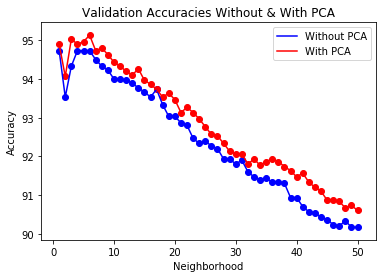

In [64]:
plt.figure()
plt.plot(n_arr,val_acc_without_pca,color='blue')
plt.scatter(n_arr,val_acc_without_pca,color='blue')
plt.plot(n_arr,val_acc_with_pca,color='red')
plt.scatter(n_arr,val_acc_with_pca,color='red')
plt.legend(['Without PCA','With PCA'])
plt.title('Validation Accuracies Without & With PCA')
plt.xlabel('Neighborhood')
plt.ylabel('Accuracy')
plt.savefig('val_acc.png')

In [65]:
optimal_neighborhood_with_pca = n_arr[np.argmax(val_acc_with_pca)]
optimal_neighborhood_without_pca = n_arr[np.argmax(val_acc_without_pca)]
print('Optimal neighborhood with PCA: %d'%optimal_neighborhood_with_pca)
print('Optimal neighborhood without PCA: %d'%optimal_neighborhood_without_pca)

Optimal neighborhood with PCA: 6
Optimal neighborhood without PCA: 1


In [66]:
knn_test = KNN()

knn_test.set_train_data(train_projections,trainY)
knn_test.set_neighborhood(optimal_neighborhood_with_pca)
predictions = knn_test.get_predictions(test_projections)
accuracy = KNN.get_accuracy(predictions[0,:],testY)
print('Accuracy with PCA: %f'%accuracy)

knn_test.set_train_data(trainX,trainY)
knn_test.set_neighborhood(optimal_neighborhood_without_pca)
predictions = knn_test.get_predictions(testX)
accuracy = KNN.get_accuracy(predictions[0,:],testY)
print('Accuracy without PCA: %f'%accuracy)




Accuracy with PCA: 94.600000
Accuracy without PCA: 94.266667
